In [1]:
# Install yfinance library
# %pip install -q yfinance --upgrade --no-cache-dir

In [3]:
# Import the necessary libraries
import requests
import pandas as pd
import yfinance as yf
import bs4 as bs
import pickle
import requests
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings("ignore")
from drift import *
from sklearn.metrics import accuracy_score

In [88]:
df = pd.read_csv(f'stocks_processed_2024-04-01.csv')

In [89]:
df[['end_of_quarter', 'increase']].idxmax

<bound method DataFrame.idxmax of       end_of_quarter  increase
0         2023-12-31       NaN
1         2023-09-30       NaN
2         2023-06-30 -0.043863
3         2023-03-31 -0.233764
4         2022-12-31 -0.054131
...              ...       ...
23988     2021-03-31  0.150489
23989     2020-12-31  0.249231
23990     2020-09-30  0.777020
23991     2020-06-30  0.417931
23992     2020-03-31  0.087163

[23993 rows x 2 columns]>

In [87]:
df[['end_of_quarter', 'increase']].idxmax

<bound method DataFrame.idxmax of       end_of_quarter  increase
0         2024-01-27 -0.046089
1         2023-10-28  0.018920
2         2023-07-29 -0.002068
3         2023-04-29  0.108682
4         2023-01-28 -0.027173
...              ...       ...
12047     2023-03-31  0.085834
12048     2022-12-31 -0.104778
12049     2022-09-30  0.170278
12050     2022-06-30  0.055162
12051     2022-03-31 -0.076444

[12052 rows x 2 columns]>

In [97]:
from IPython.display import display, HTML
from datetime import date
today = date.today()

today_str = '2024-04-01'
quartals = [
            '2021-10-01',
            '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01',
            '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01', 
            # '2024-01-01', 
            # '2024-04-01'
            ]
start_of_quartal = '2024-03-01'
accuracies = {}
for quartal in range(len(quartals)-2):
    df = pd.read_csv(f'stocks_processed_{today_str}.csv')
    final_gain = df[['ticker', 'end_of_quarter', 'end_of_quarter_release', 'increase']]
    
    # final_increase = df.loc[(df.end_of_quarter > quartals[quartal-1])].reset_index(drop=True).groupby('ticker', as_index=False)['increase'].sum()
    # remove commas from thousands, and replace values that have only '-' with nan
    tmp = df['end_of_quarter'].copy()
    for col in list(df.columns):
        try:
            df.loc[:, col] = df.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
        except:
            pass
    # all percentage columns, remove the percent sign
    percentage_columns = [col for col in df.columns if any(df[col].astype(str).str.contains('%'))]
    for col in percentage_columns:
        df.loc[:, col] = df.loc[:, col].str.replace('%', '')
    df['end_of_quarter'] = tmp

    numerical_features = list(df.columns)
    numerical_features.remove('ticker')
    numerical_features.remove('end_of_quarter')
    numerical_features.remove('industry')
    numerical_features.remove('sector')
    numerical_features.remove('increase')
    numerical_features.remove('year')
    numerical_features.remove('end_of_quarter_release')
    # numerical_features.remove('quarter_year')
    df['increase'] = df['increase'].astype('float')

    df[numerical_features] = df[numerical_features].astype('float')
    # df = df.loc[df.end_of_quarter > '2021-01-01']
    df['end_of_quarter'] = pd.to_datetime(df['end_of_quarter'])
    df['quarter_year'] = df['end_of_quarter'].dt.to_period('Q')


    df_mean = df.groupby(['quarter_year', 'industry']).mean()
    df_std = df.groupby(['quarter_year', 'industry']).std()
    dff = pd.merge(left=df, right=df_mean, how='left', on=['quarter_year', 'industry'], suffixes=["", "_mean"])
    dff = pd.merge(left=dff, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["", "_std"])
    df = dff

    _CALCULATED = 'calculated_'

    df[f"{_CALCULATED}Return on Equity (ROE)"] = 100 * df['Net Income_mean'].astype('float')/df["Shareholders' Equity"].astype('float')
    df[f'{_CALCULATED}Asset Turnover'] = df['Revenue_mean'].astype('float')/df['Total Assets'].astype('float')
    df[f"{_CALCULATED}Return on Assets (ROA)"] = 100 * df['Net Income_mean'].astype('float')/df["Total Assets"].astype('float')
    # avoid inf, add 10e-5
    df[f'{_CALCULATED}Earnings Yield'] = 1 / (df['PE Ratio'].astype('float') + 10e-5)
    df[f'{_CALCULATED}Share Price'] = df['PE Ratio'].astype('float') * df['EPS (Basic)'].astype('float')
    df[f'{_CALCULATED}FCF Yield'] = df['Free Cash Flow Per Share'].astype('float')/ (df[f'{_CALCULATED}Share Price'].astype('float') + 10e-5)
    df[f'{_CALCULATED}DPS'] = -1* df[ 'Dividends Paid'].astype('float') / (df['Shares Outstanding (Basic)'].astype('float') + 10e-5)
    df[f'{_CALCULATED}Dividents'] = df[f'{_CALCULATED}DPS'].astype('float') * df['Shares Outstanding (Basic)'].astype('float')
    # Liquidity Ratios
    df[f'{_CALCULATED}current_ratio'] = df['Total Current Assets'] /(df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}quick_ratio'] = (df['Cash & Equivalents'] + df['Short-Term Investments'] + df['Receivables']) / (df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}cash_ratio'] = (df['Cash & Equivalents'] + df['Short-Term Investments']) / (df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}operating_profit_margin'] = (df['Operating Income'] / (df['Revenue']+ 10e-5)) * 100
    df[f'{_CALCULATED}inventory_turnover'] = df['Cost of Revenue'] / (df['Inventory']+ 10e-5)
    df[f'{_CALCULATED}accounts_receivable_turnover'] = df['Revenue'] / (df['Receivables']+ 10e-5)

    calculated_feats = [x for x in df.columns if _CALCULATED in x]
    calculated_feats.extend(['quarter_year', 'industry'])
    df_mean = df[calculated_feats].groupby(['quarter_year', 'industry']).mean()
    df_std = df[calculated_feats].groupby(['quarter_year', 'industry']).std()
    dff = pd.merge(left=df_mean, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["_mean", "_std"])
    # dff = pd.merge(left=dff, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["", "_std"])
    calculated_feats.remove('quarter_year')
    calculated_feats.remove('industry')
    df = pd.concat([df, dff], axis=1)
    new_numerical_features = []
    # numerical_features.remove('increase_mean')
    # numerical_features.remove('increase_std')
    # numerical_features.remove('increase')
    for col in numerical_features:
        df[col] = (df[col] - df[col + "_mean"]) / df[col + "_std"]
        new_numerical_features.append(col)
        new_numerical_features.append(col + "_mean")
        new_numerical_features.append(col + "_std")
        
    print(f"numerical features before mean std:{len(numerical_features)}")
    numerical_features = new_numerical_features + calculated_feats + list(dff.columns)
    print(f"numerical features after mean std:{len(numerical_features)}")

    new_numerical_features = []
    for c in numerical_features:
        df[c+'_lag1'] = df.groupby('ticker')[c].shift(-1)
        new_numerical_features.append(c+'_lag1')
        df[c+'_lag2'] = df.groupby('ticker')[c].shift(-2)
        new_numerical_features.append(c+'_lag2')
        df[c+'_lag3'] = df.groupby('ticker')[c].shift(-3)
        new_numerical_features.append(c+'_lag3')
        df[c+'_lag4'] = df.groupby('ticker')[c].shift(-4)
        new_numerical_features.append(c+'_lag4')
        df[c+"_c1"] = (df[c] - df[c+'_lag1']) / (df[c+'_lag1'] + 1e-3)
        new_numerical_features.append(c+'_c1')
        df[c+"_c2"] = (df[c] - df[c+'_lag2']) / (df[c+'_lag2'] + 1e-3)
        new_numerical_features.append(c+'_c2')
        df[c+"_c3"] = (df[c] - df[c+'_lag3']) / (df[c+'_lag3'] + 1e-3)
        new_numerical_features.append(c+'_c3')
        df[c+"_c4"] = (df[c] - df[c+'_lag4']) / (df[c+'_lag4'] + 1e-3)
        new_numerical_features.append(c+'_c4')

    numerical_features += new_numerical_features
    print(f"numerical features after lag:{len(numerical_features)}")
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median()).fillna(0)
    print(f"Splitting train data according to current quarter: {quartals[quartal]}")
    df = df.loc[(df.end_of_quarter >= '2020-01-01') & (df.end_of_quarter <= quartals[quartal])]
    df['end_of_quarter'] = pd.to_datetime(df['end_of_quarter'])
    df['quarter_year'] = df['end_of_quarter'].dt.to_period('Q')

    t = df.end_of_quarter.min().to_period(freq='Q') - df.end_of_quarter.max().to_period(freq='Q')
    print(abs(t.n))

    psi_results = {}
    cols = [i for i in numerical_features if i not in ['ticker', 'end_of_quarter', 'year']]
    # Perform PSI drift analysis over quarters for each numerical feature
    psi_results = {}
    for col in cols:
        psi_results[col] = psi_drift_over_quarters(df, col, abs(t.n))

    # psi_results
    # # Convert results to DataFrame
    feats_to_keep = []
    for p in psi_results:
        # val = max(psi_results[p])
        # if val < .25:
        #     feats_to_keep.append(p)
        count = 0
        for num in psi_results[p]:
            if num < .25: 
                # print(f"{p}: {psi_results[p]}")
                count+=1
        if count >= abs(t.n)//2 + 1:
            feats_to_keep.append(p)


    print(f"kept: {len(feats_to_keep)}")
    print(f"total: {len(numerical_features)}")

    feats_to_keep.extend(['ticker', 'industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 
                        'boardrisk','shareholderrightsrisk','end_of_quarter','end_of_quarter_release','increase','quarter_year'])
    df = df[feats_to_keep]

    # One hot encoding of industry, we skip encoding of sector since we have almost all NaNs there
    one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
    df = pd.concat([df, one_hot_encoded_industry], axis=1)
    industry = df[['ticker', 'industry']]
    df.drop(['industry', 'sector'], axis=1, inplace=True)
    
    df_to_predict = df.groupby('ticker', as_index=False).first()
    df_to_predict = df_to_predict[df_to_predict.end_of_quarter > start_of_quartal]

    # df['increase_two_q'].fillna(0, inplace=True)
    # where target variable 'increase' does not exists, remove those rows
    df.dropna(axis=0, inplace=True, subset=['increase'])
    # train test split (we leave the last quarter for test)
    industry = industry.groupby('ticker').first().reset_index()
    df_test1 = df.groupby('ticker', as_index=False).first()
    df_testn = df.groupby('ticker', as_index=False).nth([0, 1])
    # df_test = pd.concat([df_test1, df_test2], axis=0)
    df_test = df_testn
    # print(df_testn.equals(df_test))
    df_test_tmp = df_test1
    df_train = df[~df.set_index(['ticker', 'end_of_quarter']).index.isin(df_test.set_index(['ticker', 'end_of_quarter']).index)]
    # da go zemam first od train i da prodolzam 
    df_test = df_test1
    y_train = df_train[['increase', 'ticker', 'end_of_quarter_release', 'end_of_quarter']]
    y_test = df_test[['increase', 'ticker', 'end_of_quarter_release', 'end_of_quarter']]
    df_test = df_test.drop(['ticker', 'end_of_quarter', 'end_of_quarter_release','increase', 'quarter_year'], axis=1)
    df_train = df_train.drop(['ticker', 'end_of_quarter', 'end_of_quarter_release', 'increase',  'quarter_year'], axis=1)
    # going from real valued 'increase' to classification problem
    y_train['increase_real_values'] = y_train.increase
    # display(y_train)
    # break
    class_thresholds = [-0.1, 0.0, 0.1, 0.2, 0.5]
    y_train.increase[(y_train.increase_real_values >= class_thresholds[4])] = 5
    y_train.increase[(y_train.increase_real_values >= class_thresholds[3]) & (y_train.increase_real_values < class_thresholds[4])] = 4
    y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
    y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
    y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
    y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0
    # We fill all NaN values with maxint from numpy. Currently, we are not sure if this is financially correct (?)
    df_train.fillna(np.iinfo('int').max, inplace=True)
    df_test.fillna(np.iinfo('int').max, inplace=True)
    # Assuming you have your features (x) and labels (y) ready, split the data.
    X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)
    # We fit a classifier to predict the increase in percentage into the next Q
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=50)#, class_weight=class_weights)
    # Fit the model to the training data
    rf_classifier.fit(X_train, Y_train.increase)
    # Predict on the test set just as sanity check
    rf_classifier.predict(X_test)
    ticker = Y_test.ticker
    p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
    # Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
    accuracy = accuracy_score(p.true, p.preds)
    # proba = rf_classifier.predict_proba(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])[rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])== np.max(rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]))]
    proba = rf_classifier.predict_proba(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])[np.isin(rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]),[4,5])]

    # predicting on the SNP 500 stocks
    p = pd.DataFrame({  "ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, 
                        "end_of_quarter_release": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].end_of_quarter_release, 
                        "end_of_quarter": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].end_of_quarter, 
                        "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]),
                        "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
    # selecting the top K stocks we want to put money in
    p[p.preds.isin([4, 5])]
    b = p[p.preds.isin([4, 5])]
    b['proba'] = [np.max(row) for row in proba]
    b = pd.merge(left=b, right=industry, on=['ticker'])
    p['increase_q'] = p.increase
    class_thresholds = [-0.1, 0.0, 0.1, 0.2, 0.5]
    p.increase_q[(p.increase >= class_thresholds[4])] = 5
    p.increase_q[(p.increase >= class_thresholds[3]) & (p.increase < class_thresholds[4])] = 4
    p.increase_q[(p.increase >= class_thresholds[2]) & (p.increase < class_thresholds[3])] = 3
    p.increase_q[(p.increase >= class_thresholds[1]) & (p.increase < class_thresholds[2])] = 2
    p.increase_q[(p.increase > class_thresholds[0]) & (p.increase < class_thresholds[1])] = 1
    p.increase_q[p.increase <= class_thresholds[0]] = 0
    # Compute accuracy on test
    test_accuracy = accuracy_score(p.increase_q, p.preds)

    bb = b.sort_values(by=["preds", "proba"], ascending = False).iloc[:10]
    bb = bb.loc[bb.end_of_quarter > (pd.to_datetime(quartals[quartal]) - pd.DateOffset(months=3))]
    b = bb
    accuracies[quartals[quartal]] = {"val":accuracy, "test": test_accuracy, 
                                     "gain": f'{b.sort_values(by=["preds", "proba"], ascending = False).iloc[:10].increase.mean()  * 100}%',
                           "data": b.sort_values(by=["preds", "proba"], ascending = False).iloc[:10], "data_full": b.sort_values(by=["preds", "proba"], ascending = False).iloc[:15]}
    final_gain.end_of_quarter = pd.to_datetime(final_gain.end_of_quarter)
    final_gain.end_of_quarter_release = pd.to_datetime(final_gain.end_of_quarter_release)
    a = df_test_tmp[['ticker', 'end_of_quarter', 'end_of_quarter_release','increase']].loc[df_test_tmp.ticker.isin(accuracies[quartals[quartal]]['data'].ticker)]
    f_gain = {}
    for tick in a.ticker:
        aa = final_gain[final_gain.ticker == tick]
        f_gain[tick] = aa[aa.end_of_quarter_release >= df_test_tmp.loc[df_test_tmp.ticker == tick].end_of_quarter_release.values[0]].increase.sum()

    suma = 0
    for k in f_gain:
        suma += f_gain[k]
    
    accuracies[quartals[quartal]]["f_gain_percent"] = (suma * 100 / len(f_gain))
    accuracies[quartals[quartal]]["f_gain"] = f_gain
    print(f'val:{accuracies[quartals[quartal]]["val"]}, test: {accuracies[quartals[quartal]]["test"]},gain:{accuracies[quartals[quartal]]["gain"]},f_gain_percent:{accuracies[quartals[quartal]]["f_gain_percent"]}')
    print(f'Top 5 stocks')
    display(accuracies[quartals[quartal]]["data"])
    print("######################")

numerical features before mean std:139
numerical features after mean std:459
numerical features after lag:4131
Splitting train data according to current quarter: 2021-10-01
7
kept: 1248
total: 4131
val:0.38181818181818183, test: 0.1494949494949495,gain:-23.935043230341748%,f_gain_percent:-33.09256872618386
Top 5 stocks


,ticker,end_of_quarter_release,end_of_quarter,preds,increase,proba,industry
120,TSLA,2021-10-26,2021-09-30,5.0,-0.020041,0.345,Auto Manufacturers
40,EPAM,2021-11-06,2021-09-30,5.0,-0.517763,0.308,Information Technology Services
43,ETSY,2021-11-05,2021-09-30,5.0,-0.579694,0.272,Internet Retail
48,FCX,2021-11-06,2021-09-30,5.0,0.006999,0.245,Copper
1,ABNB,2021-11-06,2021-09-30,5.0,-0.285693,0.221,Travel Services
92,PAYC,2021-11-05,2021-09-30,5.0,-0.349326,0.220,Software—Application
51,FTNT,2021-11-09,2021-09-30,5.0,-0.236893,0.210,Software—Infrastructure
70,MCO,2021-10-30,2021-09-30,4.0,-0.194491,0.558,Financial Data & Stock Exchanges
96,PSA,2021-11-02,2021-09-30,4.0,0.106285,0.541,REIT—Industrial
77,MSCI,2021-10-27,2021-09-30,4.0,-0.322887,0.539,Financial Data & Stock Exchanges


######################
numerical features before mean std:139
numerical features after mean std:459
numerical features after lag:4131


KeyboardInterrupt: 

In [71]:
accuracies

{'2021-10-01': {'val': 0.3581395348837209,
  'test': 0.323943661971831,
  'gain': '36.3403219893965%',
  'data':    ticker end_of_quarter_release end_of_quarter  preds  increase  proba  \
  16    DVN             2021-11-04     2021-09-30    5.0  0.542543  0.273   
  35    MRO             2021-11-05     2021-09-30    5.0  0.633366  0.269   
  12    COP             2021-11-05     2021-09-30    5.0  0.387304  0.245   
  42    OXY             2021-11-05     2021-09-30    5.0  0.842909  0.242   
  2     APA             2021-11-06     2021-09-30    5.0  0.352252  0.239   
  17    EOG             2021-11-05     2021-09-30    5.0  0.352073  0.227   
  39   NVDA             2021-08-21     2021-08-01    5.0  0.076692  0.196   
  44    PSA             2021-11-02     2021-09-30    4.0  0.106285  0.508   
  40    OKE             2021-11-04     2021-09-30    4.0  0.042684  0.475   
  6     BKR             2021-10-23     2021-09-30    4.0  0.297924  0.452   
  
                            industry  


In [76]:
suma =  0
capital = 1000
start_capital = capital
for k in accuracies:
    if k == '2024-01-01':
        continue
    suma += float(accuracies[k]['gain'][:-1])
    capital += capital * float(accuracies[k]['gain'][:-1]) / 100

print("The summed gain over the quartals is: ", suma, "%")
print(f'Starting with {start_capital} USD, over {len(accuracies)} quartals, we will end up with {capital} USD')

suma =  0
capital = 1000
reinvestment_every_quartal = 2100
start_capital = capital
for k in accuracies:
    if k == '2024-01-01':
        continue
    suma += float(accuracies[k]['gain'][:-1])
    capital += capital * float(accuracies[k]['gain'][:-1]) / 100 + reinvestment_every_quartal

print(f'Starting with {start_capital} USD, over {len(accuracies)} quartals, if we add {reinvestment_every_quartal} USD plus every quartal, we will end up with {capital} USD')
print(f'Out of {capital} USD, our investment accounts {start_capital + reinvestment_every_quartal *len(accuracies)}, while the gain accounts for {capital - (start_capital + reinvestment_every_quartal *len(accuracies))}')

The summed gain over the quartals is:  208.7200289679272 %
Starting with 1000 USD, over 10 quartals, we will end up with 6292.764745204523 USD
Starting with 1000 USD, over 10 quartals, if we add 2100 USD plus every quartal, we will end up with 53809.4411583411 USD
Out of 53809.4411583411 USD, our investment accounts 22000, while the gain accounts for 31809.4411583411


<Figure size 1600x1600 with 0 Axes>

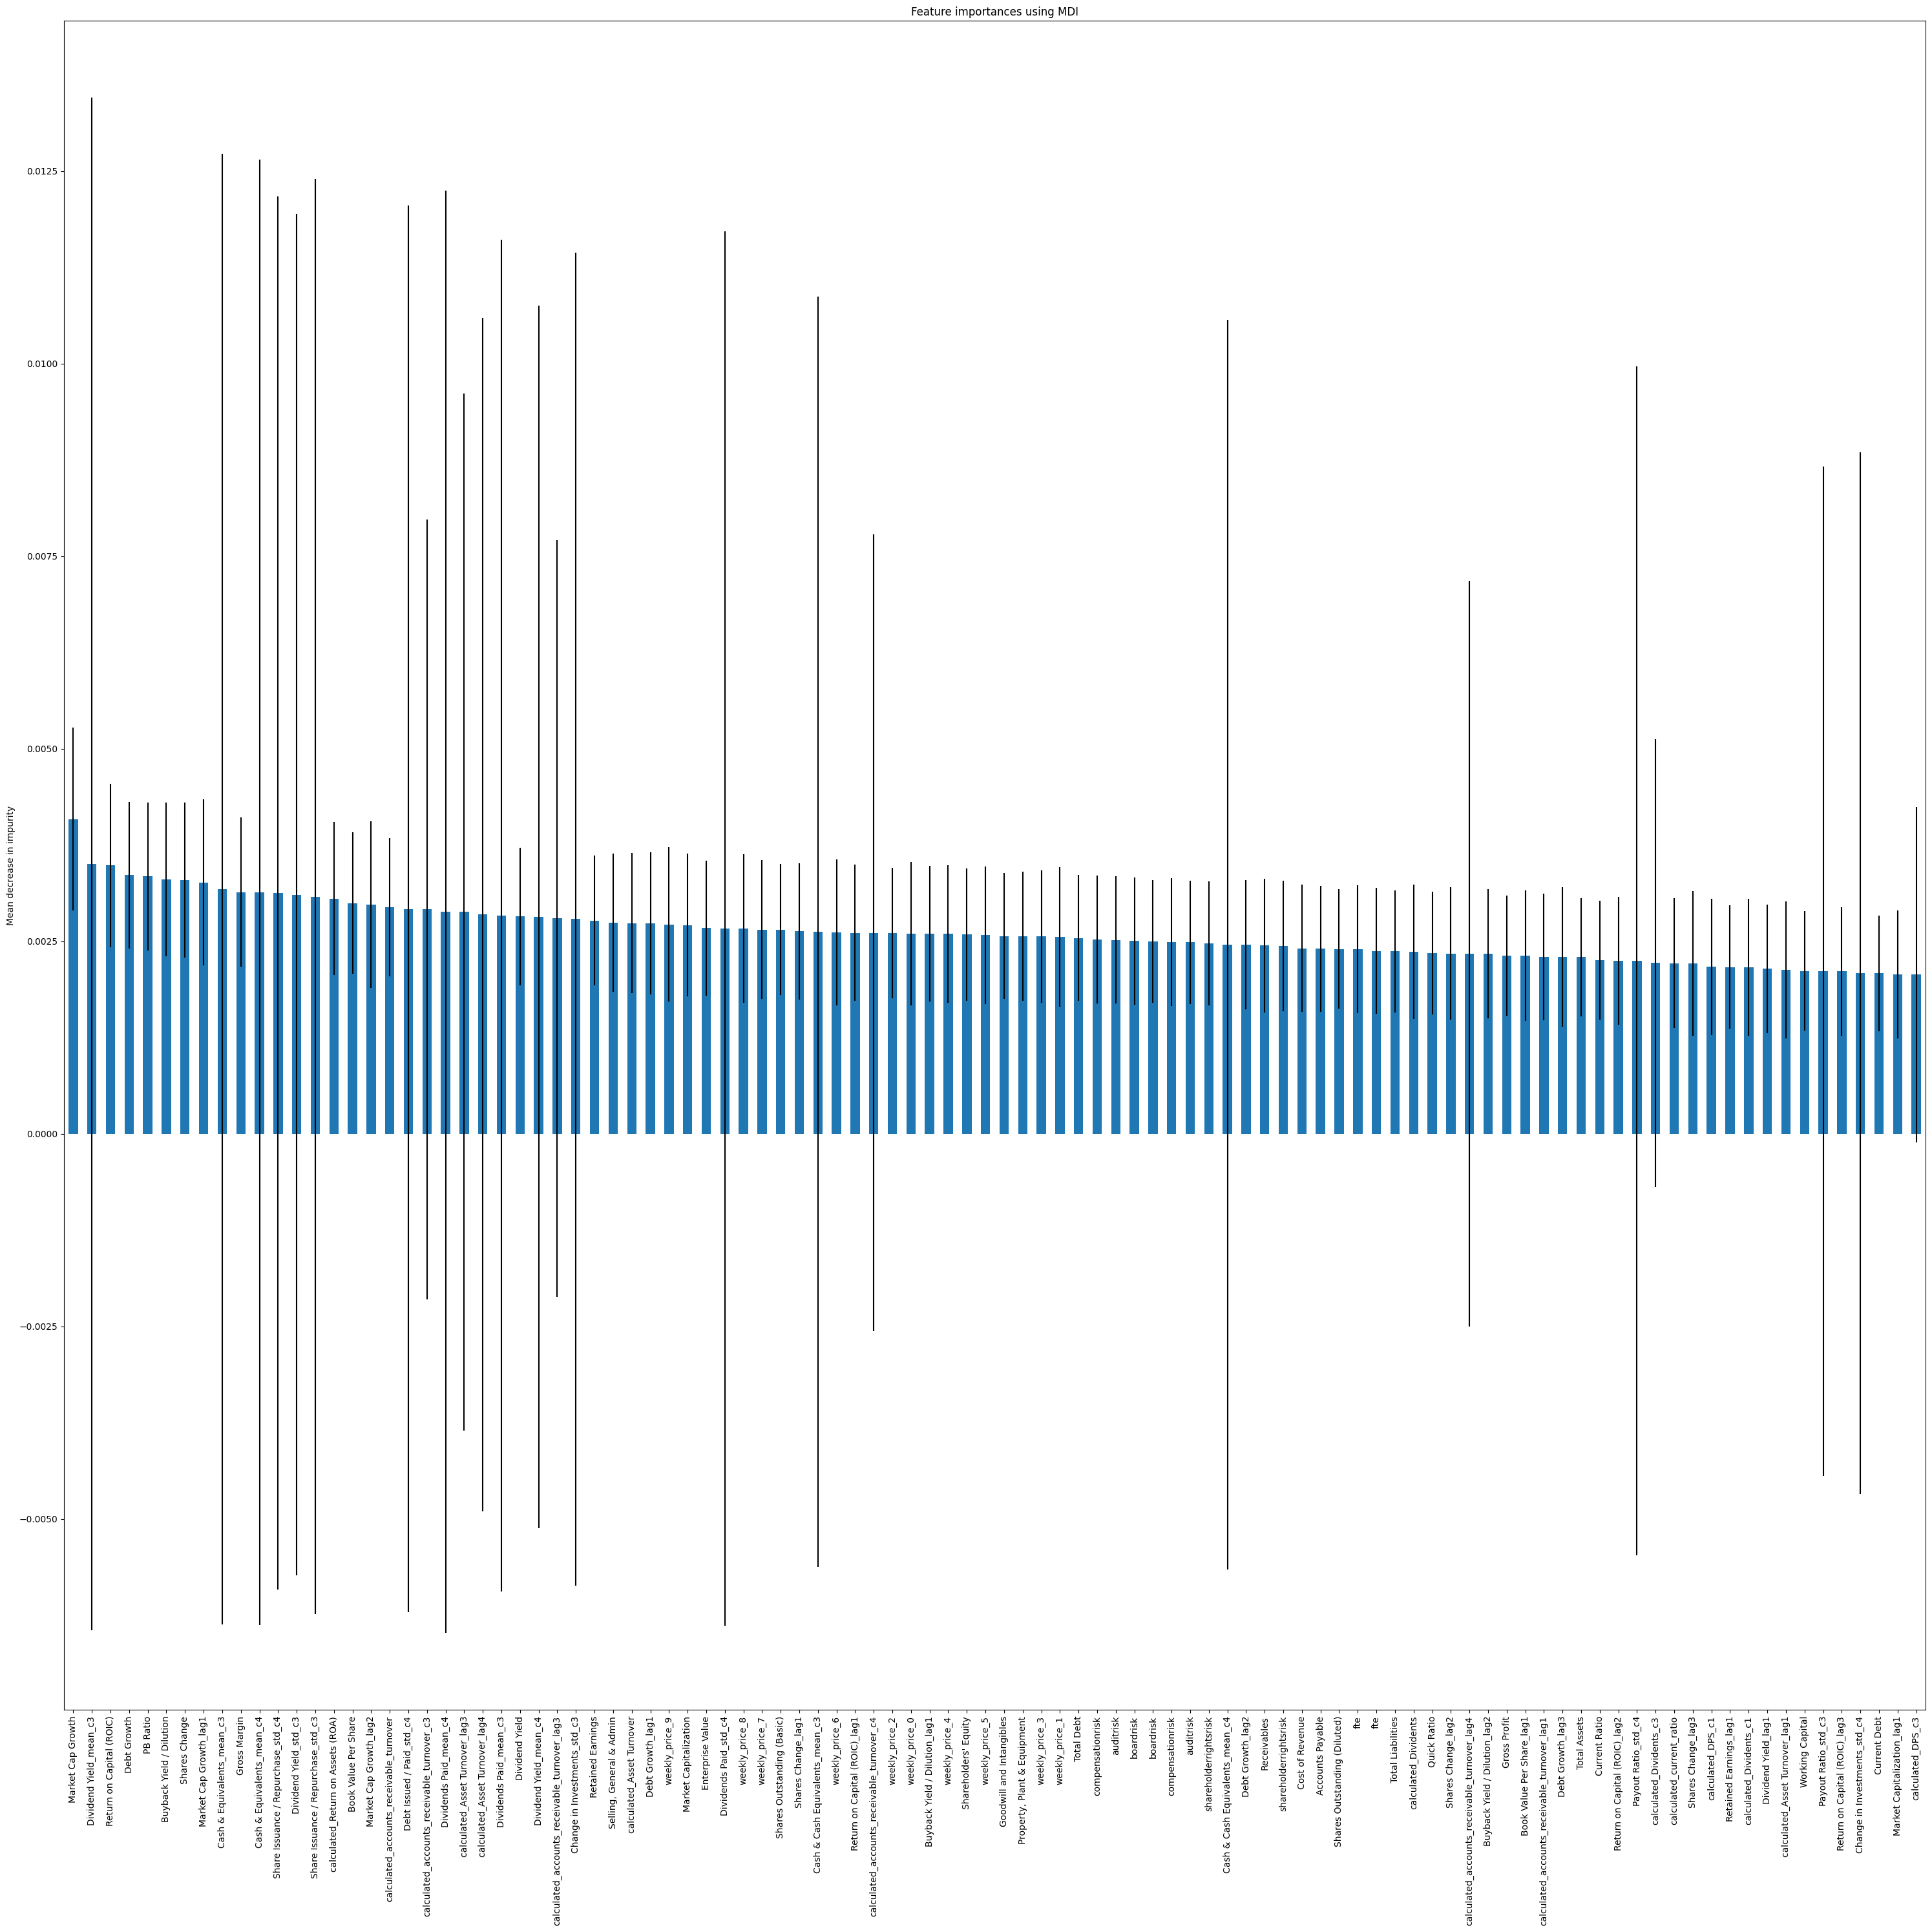

In [10]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.DataFrame({'importances':importances, 'std':std}, index=list(df_train.columns))
forest_importances = forest_importances.sort_values(by = 'importances', ascending=False).iloc[:100]
plt.figure(figsize=(16,16))
fig, ax = plt.subplots(figsize=(30,30))
forest_importances['importances'].plot.bar(yerr=forest_importances['std'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png')